In [1]:
import os
ROOT='../..'
os.chdir(ROOT)

%run config/initialize.ipynb

In [2]:
import mpl_style
rcParams['figure.dpi'] = 96
rcParams['figure.figsize'] = (12,8)

## Weather Features
* #### NOTE: weather might not be known for opening line, only closing line
* key: (game_id)
* table name: features.weather
* __wind_chill__
* __humidity_pct__
* __temperature__
* __wind_mph__
* __is_grass__
* __is_dome__

In [3]:
key = 'game_id'
out_tbl = 'features.weather'
features_list = []

### inspect/parse pfr_weather field

In [4]:
df = spark.table('game_metadata').select(
    'game_id','pfr_weather','roof','surface'
).toPandas()

#### NULL values are encoded as string 'nan'
* #### TODO: move this fix into the "write hive tables" process

#### first 2 words are always "[#] degrees"

#### 3rd+ words
* usually "relative humidity"
* otherwise 
  * "wind [#] mph"
  * "no wind"

In [5]:
pd.options.display.max_rows = 10000

In [6]:
def parse_weather(x):
    '''parse pfr_weather field and extract
    relevant info'''
    weather = {}
    if x == 'nan':
        return None
    else:
        ## extract temperature and remove 2nd token
        weather['temperature'] = int(x.split(' ')[0])
        x = ' '.join(x.split(' ')[2:])
        
        ## if next 2 tokens are "relative humidity"
        ## then the 3rd is the humidity in %
        ## otherwise, humidity is 0
        if x.startswith('relative humidity'):
            weather['humidity'] = int(x.split(' ')[2].split('%')[0])
            x = ' '.join(x.split(' ')[3:])
        else:
            weather['humidity'] = 0
            
        ## if next 2 tokens are "no wind" then wind is 0
        ## otherwise it's "wind [#] mph"
        if x.startswith('no wind'):
            weather['wind'] = 0
            x = ' '.join(x.split(' ')[2:])
        else:
            weather['wind'] = int(x.split(' ')[1])
            x = ' '.join(x.split(' ')[3:])
        
        ## if next 2 tokens are "wind chill" then
        ## 3rd token is the temp
        if x.startswith('wind chill'):
            weather['wind_chill'] = int(x.split(' ')[2])
            x = ' '.join(x.split(' ')[3:])
        else:
            weather['wind_chill'] = None

        return weather

In [7]:
weather = df.set_index('game_id')['pfr_weather'].apply(parse_weather).apply(pd.Series)

In [8]:
df_weather = df.merge(weather, left_on='game_id', right_index=True)

In [9]:
nulls = df_weather.copy()
for c in nulls.columns:
    if c not in ['surface','roof','game_id']:
        nulls[c] = nulls[c].apply(lambda x: 1 if str(x) == 'nan' or x == None else 0)

In [10]:
nulls.mean(axis=0).sort_values()

pfr_weather    0.267280
humidity       0.267280
temperature    0.267280
wind           0.267280
wind_chill     0.515492
dtype: float64

In [11]:
df_weather.head()

,game_id,pfr_weather,roof,surface,humidity,temperature,wind,wind_chill
0,200909140nwe,"70 degrees relative humidity 53%, wind 5 mph, ...",outdoors,fieldturf,53.0,70.0,5.0,0.0
1,200911150oti,"68 degrees relative humidity 50%, wind 5 mph",outdoors,grass,50.0,68.0,5.0,NaN
2,200912270atl,nan,dome,fieldturf,NaN,NaN,NaN,NaN
3,200912130kan,"42 degrees relative humidity 80%, wind 3 mph, ...",outdoors,grass,80.0,42.0,3.0,0.0
4,201001030min,nan,dome,fieldturf,NaN,NaN,NaN,NaN


In [12]:
nulls.head()

,game_id,pfr_weather,roof,surface,humidity,temperature,wind,wind_chill
0,200909140nwe,0,outdoors,fieldturf,0,0,0,0
1,200911150oti,0,outdoors,grass,0,0,0,1
2,200912270atl,1,dome,fieldturf,1,1,1,1
3,200912130kan,0,outdoors,grass,0,0,0,0
4,201001030min,1,dome,fieldturf,1,1,1,1


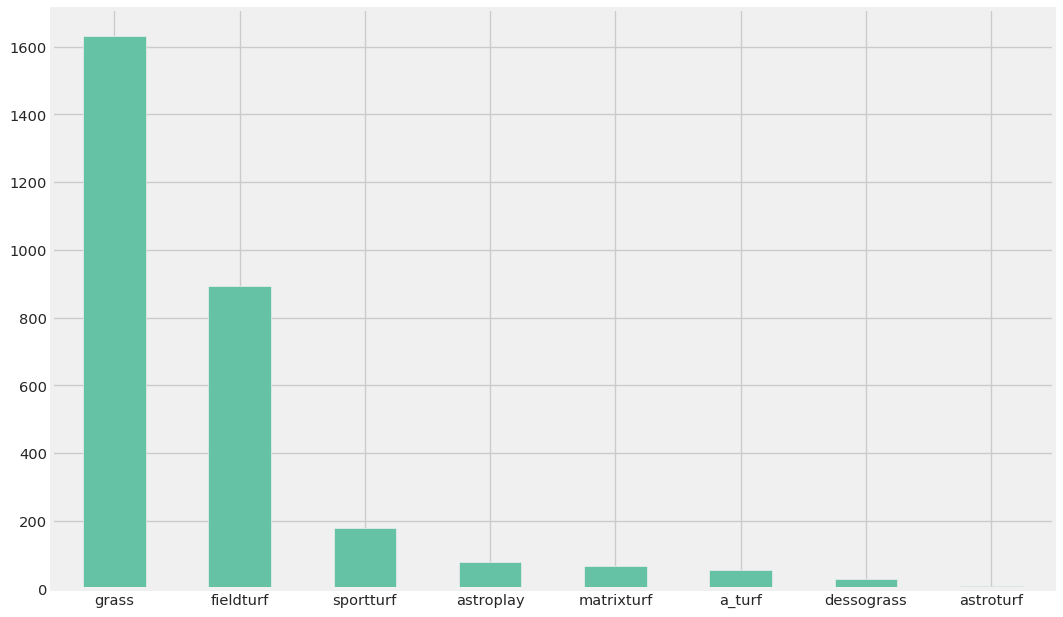

In [13]:
df_weather['surface'].value_counts().plot(
    kind='bar', legend=None, color=colors[0], rot=0,
)

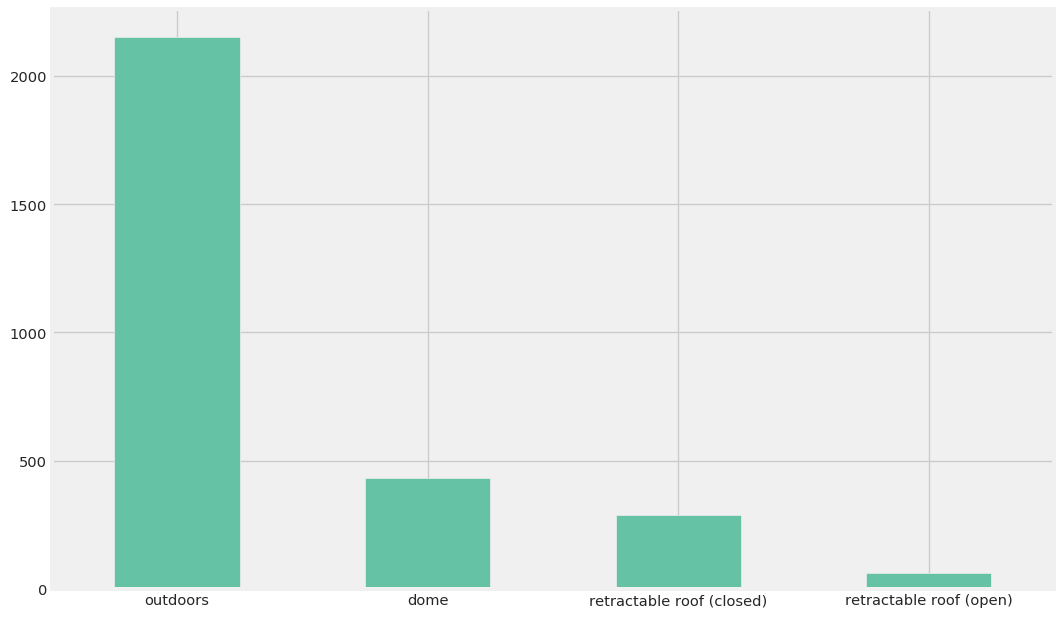

In [14]:
df_weather['roof'].value_counts().plot(
    kind='bar', legend=None, color=colors[0], rot=0,
)

### nulls by location type

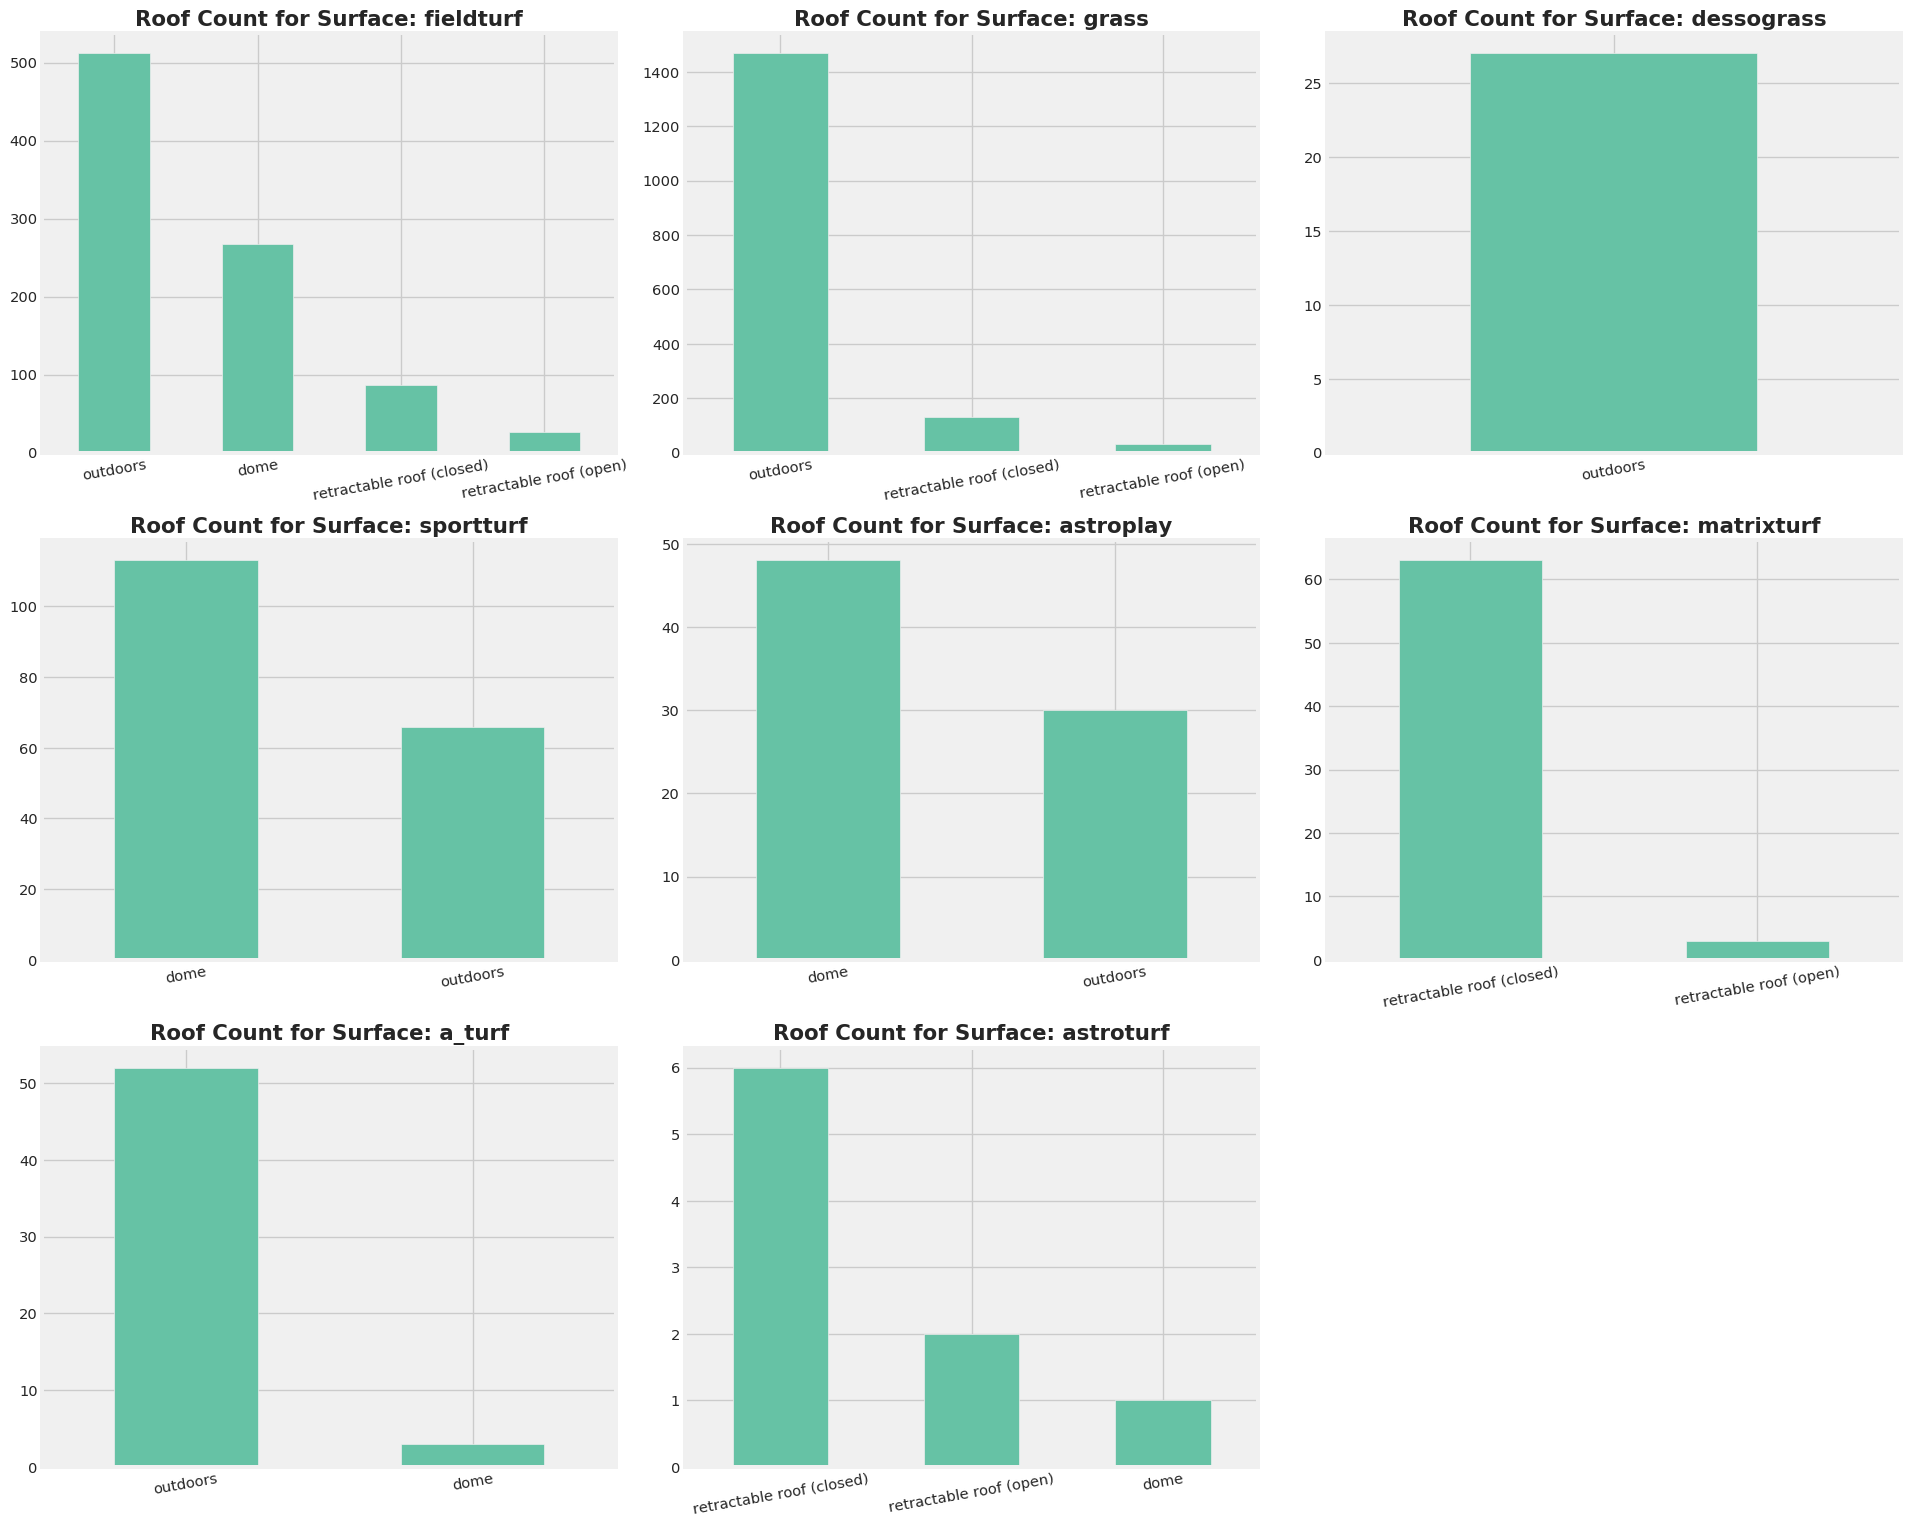

In [15]:
fig = plt.figure(figsize=(20,16))
for i, s in enumerate(df_weather['surface'].unique()):
    ax = fig.add_subplot(3,3,i+1)
    _ = df_weather[df_weather['surface'] == s]\
            ['roof']\
            .value_counts()\
            .sort_values(ascending=False)\
            .plot(
                kind='bar', 
                rot=10,
                color=colors[0],
                title='Roof Count for Surface: {}'.format(s), 
                ax=ax
            )
    plt.tight_layout()

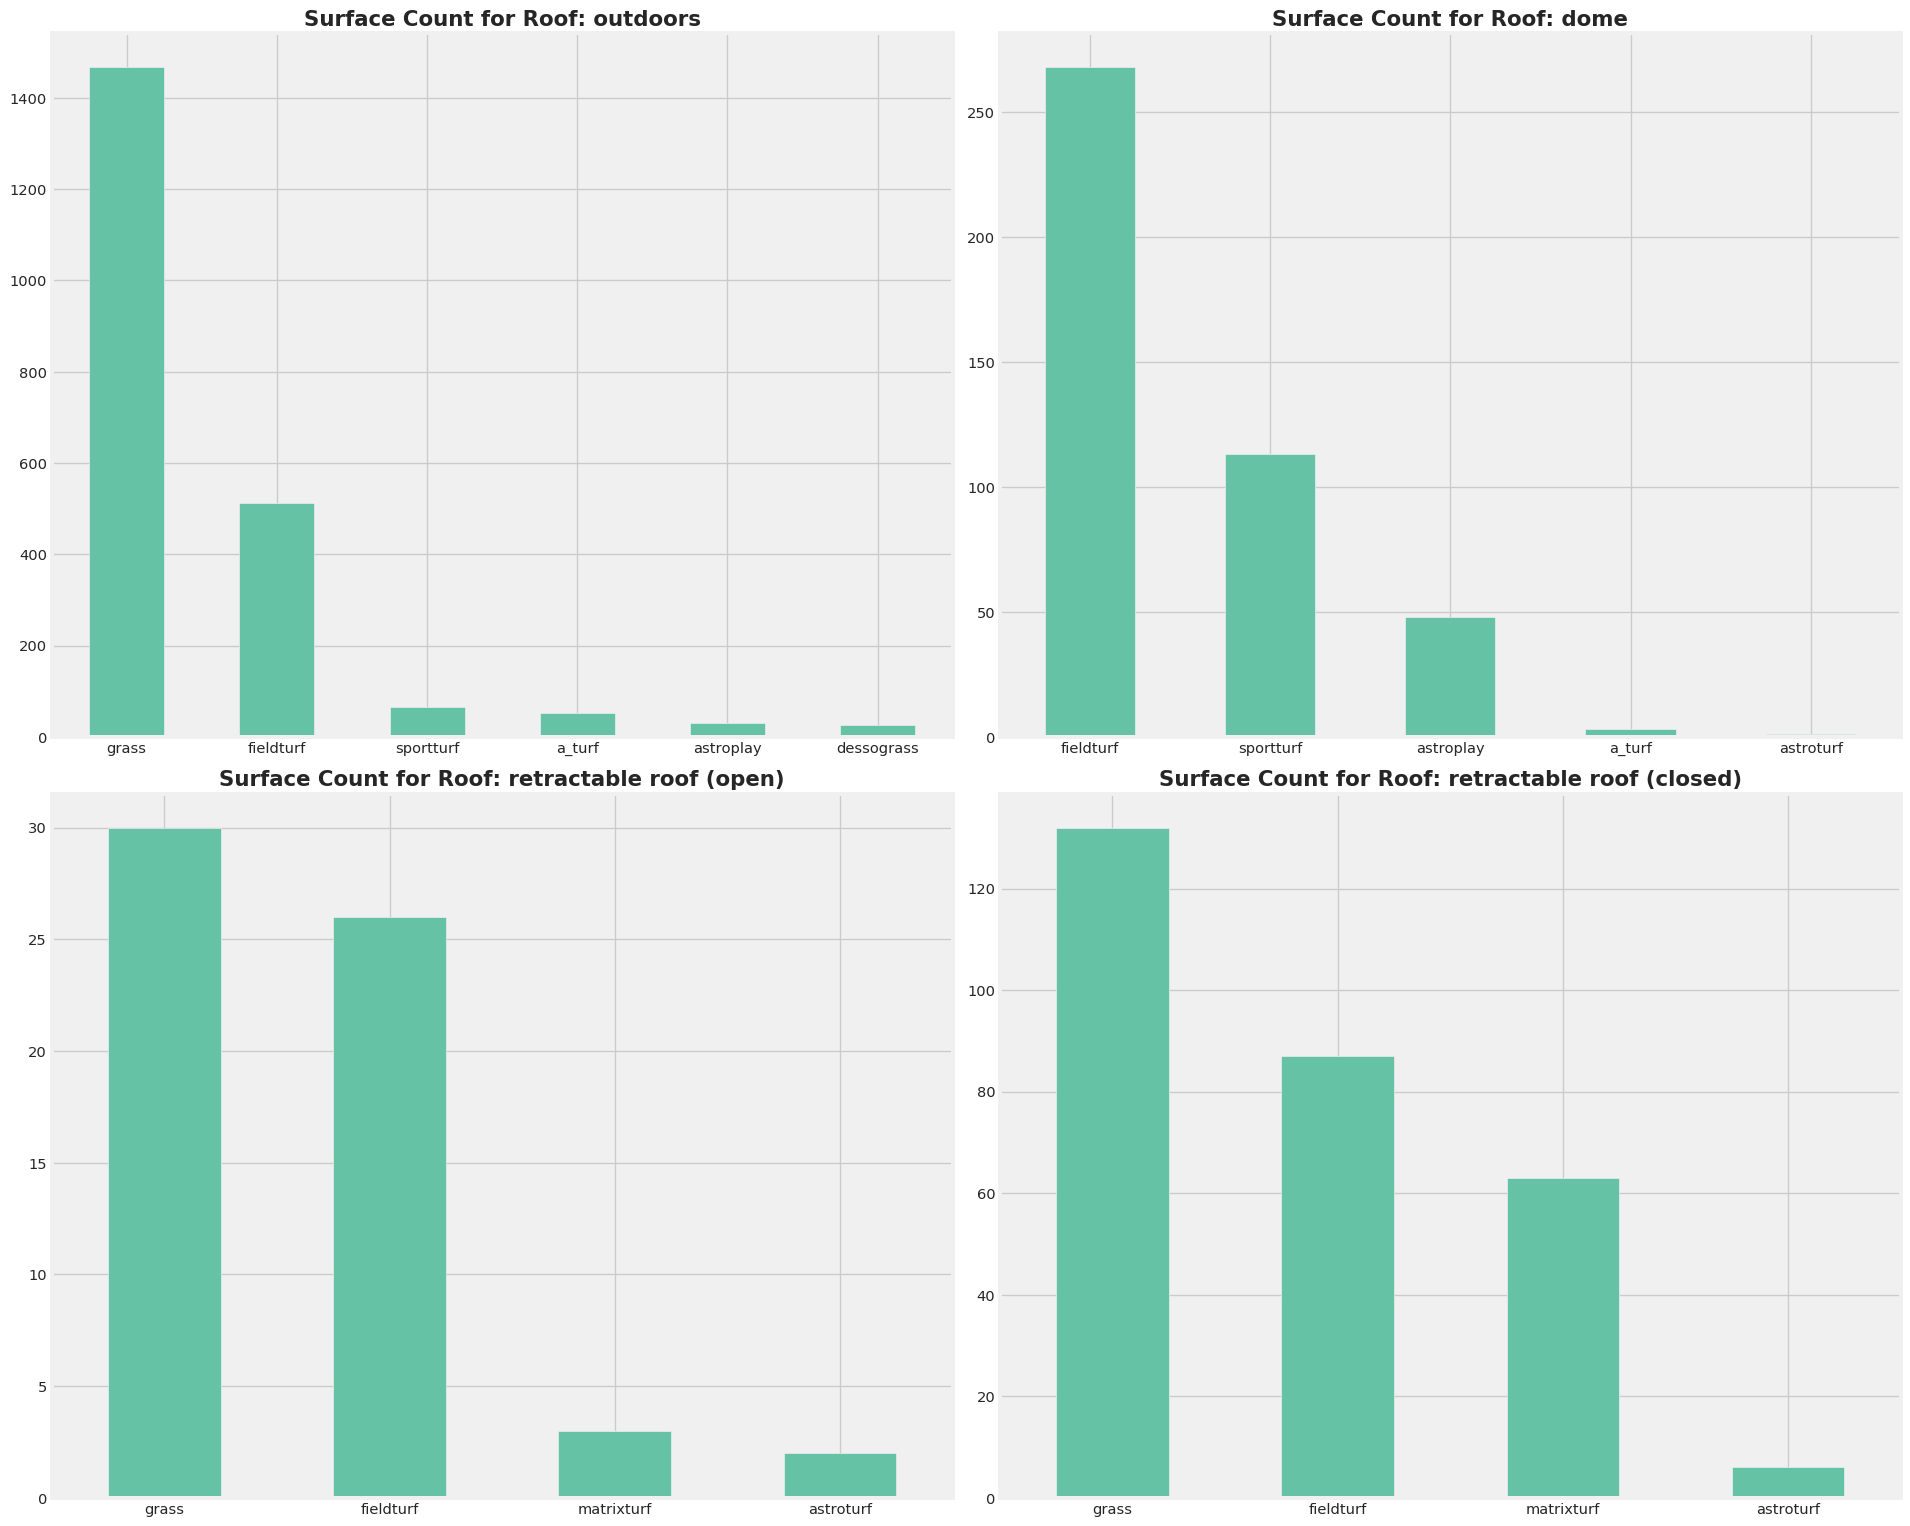

In [16]:
fig = plt.figure(figsize=(20,16))
for i, s in enumerate(df_weather['roof'].unique()):
    ax = fig.add_subplot(2,2,i+1)
    _ = df_weather[df_weather['roof'] == s]\
            ['surface']\
            .value_counts()\
            .sort_values(ascending=False)\
            .plot(
                kind='bar', 
                rot=0,
                color=colors[0],
                title='Surface Count for Roof: {}'.format(s), 
                ax=ax
            )
    plt.tight_layout()

In [17]:
df_weather['roof'].value_counts()

outdoors                     2155
dome                          433
retractable roof (closed)     288
retractable roof (open)        61
Name: roof, dtype: int64

In [18]:
df_weather['surface'].value_counts()

grass         1630
fieldturf      893
sportturf      179
astroplay       78
matrixturf      66
a_turf          55
dessograss      27
astroturf        9
Name: surface, dtype: int64

#### Surface
* grass vs. not grass

#### Roof
* dome vs. no dome

In [19]:
## non-outdoors always has null weather
for t in ['humidity','temperature','wind','wind_chill']:
    nulls[nulls['roof'] != 'outdoors'][t].value_counts()

1    782
Name: humidity, dtype: int64

1    782
Name: temperature, dtype: int64

1    782
Name: wind, dtype: int64

1    782
Name: wind_chill, dtype: int64

In [20]:
## 
for t in ['humidity','temperature','wind','wind_chill']:
    nulls[nulls['roof'] == 'outdoors'][t].value_counts()

0    2152
1       3
Name: humidity, dtype: int64

0    2152
1       3
Name: temperature, dtype: int64

0    2152
1       3
Name: wind, dtype: int64

0    1423
1     732
Name: wind_chill, dtype: int64

### Build features

In [21]:
def parse_weather(x, return_key):
    '''parse pfr_weather field and extract
    relevant info'''
    weather = {}
    if x == 'nan':
        return None
    else:
        ## extract temperature and remove 2nd token
        weather['temperature'] = int(x.split(' ')[0])
        x = ' '.join(x.split(' ')[2:])
        
        ## if next 2 tokens are "relative humidity"
        ## then the 3rd is the humidity in %
        ## otherwise, humidity is 0
        if x.startswith('relative humidity'):
            weather['humidity_pct'] = int(x.split(' ')[2].split('%')[0])
            x = ' '.join(x.split(' ')[3:])
        else:
            weather['humidity_pct'] = 0
            
        ## if next 2 tokens are "no wind" then wind is 0
        ## otherwise it's "wind [#] mph"
        if x.startswith('no wind'):
            weather['wind_mph'] = 0
            x = ' '.join(x.split(' ')[2:])
        else:
            weather['wind_mph'] = int(x.split(' ')[1])
            x = ' '.join(x.split(' ')[3:])
        
        ## if next 2 tokens are "wind chill" then
        ## 3rd token is the temp
        if x.startswith('wind chill'):
            wind_chill_val = int(x.split(' ')[2])
            
            ## 0 wind chill is used as a NULL value.
            ## if temperature is over 32 and wind chill is 0
            ## (7 games)
            if (wind_chill_val == 0) & (weather['temperature'] > 32):
                weather['wind_chill'] = weather['temperature']
            else:
                weather['wind_chill'] = wind_chill_val
            x = ' '.join(x.split(' ')[3:])
        else:
            ## if wind chill is not mentioned, then use temperature
            weather['wind_chill'] = weather['temperature']

        return float(weather[return_key])
    
parse_weather_udf = udf(parse_weather, FloatType())

In [22]:
fillna_dict = {
    'temperature': 68.,
    'humidity_pct': 0.,
    'wind_mph': 0.,
    'wind_chill': 68.
}

weather = spark.table('game_metadata').select(
    'game_id','pfr_weather','roof','surface'
)

for c in fillna_dict.keys():
    weather = weather.withColumn(
            c, parse_weather_udf('pfr_weather', F.lit(c))
        ).fillna(fillna_dict[c])
    
    features_list.append(c)

In [23]:
weather = weather.withColumn(
        'is_grass', F.when(col('surface') == 'grass', 1).otherwise(0)
    ).withColumn(
        'is_dome', F.when(col('surface') != 'outdoors', 1).otherwise(0)
    )

features_list += ['is_grass','is_dome']

## Write table

In [24]:
print '* __' + '__\n* __'.join(features_list) + '__'

* __wind_chill__
* __humidity_pct__
* __temperature__
* __wind_mph__
* __is_grass__
* __is_dome__


In [25]:
weather.select(*([key] + features_list))\
              .write.mode('overwrite').saveAsTable(out_tbl)

In [27]:
spark.table(out_tbl).limit(5).toPandas()

,game_id,wind_chill,humidity_pct,temperature,wind_mph,is_grass,is_dome
0,200810050det,68.0,0.0,68.0,0.0,0,1
1,200810120atl,68.0,0.0,68.0,0.0,0,1
2,200809070clt,68.0,0.0,68.0,0.0,0,1
3,200811300gnb,30.0,75.0,37.0,10.0,1,1
4,200809210min,68.0,0.0,68.0,0.0,0,1
